## Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях».


Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.


Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

## 1.  Выгрузим данные и подключим библиотеки

In [1]:
# это нам нужно, чтобы избежать ошибки в OHE и такиудалить одну из колонок, чтобы избежать мультиколлинерарности
!pip install scikit-learn==1.1.3
!pip install category_encoders

##  Откройте файлы с данными

In [2]:
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score 
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce 
from category_encoders import TargetEncoder

In [3]:
try:
    df_1 = pd.read_csv('/datasets/hotel_train.csv')
    df_1.info()
except:
    print('alarm, волк унес зайчат')

    
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [4]:
try:
    df_2 = pd.read_csv('/datasets/hotel_test.csv')
    df_2.info()
except:
    print('alarm, волк унес зайчат')

    
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Пропусков в данных нет, все выгружается без ошибок, надо поменять тип данных в некторых колонках, двигаемся дальше исправлять ошибки

## 2. Работа с данными

### Предобработка данных

#### Проверим на наличие дубликатов

In [5]:
print(df_1['id'].duplicated().sum())
print(df_2['id'].duplicated().sum())

0
0


Проверим на наличие не явных дубликатов

In [6]:
print(df_1['arrival_date_month'].unique())
print(df_1['meal'].unique())
print(df_1['country'].unique())
print(df_1['distribution_channel'].unique())
print(df_1['reserved_room_type'].unique())
print(df_1['customer_type'].unique())
print(df_1['arrival_date_year'].unique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB'

In [7]:
print(df_2['arrival_date_month'].unique())
print(df_2['meal'].unique())
print(df_2['country'].unique())
print(df_2['distribution_channel'].unique())
print(df_2['reserved_room_type'].unique())
print(df_2['customer_type'].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'
 'KIR' 'SDN' 'PRI' 'ATF' 'CMR' 'TJK' 'LBY' 'SLE' 'SLV' 'LAO' 'FRO']
['TA/TO

In [8]:
df_1['country'].value_counts()

PRT    28831
FRA     5974
GBR     5109
ESP     4900
DEU     3887
       ...  
HND        1
VGB        1
BFA        1
MLI        1
BDI        1
Name: country, Length: 155, dtype: int64

In [9]:
df_2['country'].value_counts()

PRT    9887
GBR    3927
FRA    3477
DEU    2378
ESP    1932
       ... 
LBY       1
GAB       1
JEY       1
SDN       1
ABW       1
Name: country, Length: 143, dtype: int64

Нужно подправить формат значений в столбцах `meal` и `reserved_room_type` , а то как то не по человечески выглядит

In [10]:
df_1['adults'].unique()

array([1., 2., 3., 4., 0.])

In [11]:
df_2['adults'].unique()

array([2., 1., 3., 4., 0.])

Врядли взрослы может быть 0, заменим 0 на медиану

In [12]:
mask_1 = (df_1['adults'].eq(0))
df_1.loc[mask_1, 'adults'] = np.nan
df_1['adults'] = df_1['adults'].fillna(df_1['adults'].median())
df_1['adults'].unique()

array([1., 2., 3., 4.])

In [13]:
mask_2 = (df_2['adults'].eq(0))
df_2.loc[mask_2, 'adults'] = np.nan
df_2['adults'] = df_2['adults'].fillna(df_2['adults'].median())
df_2['adults'].unique()

array([2., 1., 3., 4.])

Исправленно

In [14]:
df_1['meal'] = df_1['meal'].str.strip()
df_1['reserved_room_type'] = df_1['reserved_room_type'].str.strip()

df_2['meal'] = df_2['meal'].str.strip()
df_2['reserved_room_type'] = df_2['reserved_room_type'].str.strip()

In [15]:
print(df_1['meal'].unique())
print(df_1['reserved_room_type'].unique())

print(df_2['meal'].unique())
print(df_2['reserved_room_type'].unique())

['BB' 'FB' 'HB' 'SC']
['A' 'C' 'D' 'E' 'G' 'F' 'B']
['BB' 'HB' 'SC' 'FB']
['A' 'E' 'G' 'D' 'F' 'C' 'B']


Вроде стало похоже на правду=)

Исправим тип данных у столбцов, вряд ли человек может быть дробью =)

In [16]:
df_1['adults'] = df_1['adults'].astype('int64')
df_1['children'] = df_1['children'].astype('int64')
df_1['babies'] = df_1['babies'].astype('int64')



df_2['adults'] = df_2['adults'].astype('int64')
df_2['children'] = df_2['children'].astype('int64')
df_2['babies'] = df_2['babies'].astype('int64')

In [17]:
print(df_1.info())
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  int64  
 10  children                        65229 non-null  int64  
 11  babies                          65229 non-null  int64  
 12  meal                            

Супер! едем дальше

### Проведите исследовательский анализ представленных данных. Опишите найденные особенности: пропуски, выбросы

Начнем проверку на выбросы

In [18]:
df_1.describe(include='all')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,...,65229.000000,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229.000000
unique,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,October,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,9255,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50501,NaN,NaN,45493,NaN,NaN,NaN
mean,43544.069172,0.368609,96.337917,2015.719021,NaN,31.339772,15.847813,0.825185,2.224793,1.841666,...,0.027151,0.128915,0.107713,NaN,0.194269,3.334422,NaN,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,NaN,13.464024,8.748182,0.853477,1.354992,0.471268,...,0.162523,0.965326,1.326638,NaN,0.593838,18.239606,NaN,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,NaN,21.000000,8.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,NaN,34.000000,16.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,NaN,42.000000,23.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,1.000000,4.000000


In [19]:
df_2.describe(include='all')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,...,32412.000000,32412.000000,32412.000000,32412,32412.000000,32412.000000,32412,32412.000000,32412.000000,32412.000000
unique,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,May,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,5262,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23471,NaN,NaN,27461,NaN,NaN,NaN
mean,60131.505183,0.388467,97.587869,2017.0,NaN,17.804054,15.656948,0.867888,2.34009,1.862859,...,0.031377,0.011601,0.171418,NaN,0.216741,0.262341,NaN,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,NaN,9.177384,8.766429,0.853394,1.37517,0.481794,...,0.174338,0.180473,1.875170,NaN,0.640551,4.733027,NaN,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,NaN,1.000000,1.000000,0.000000,0.00000,1.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,NaN,10.000000,8.000000,0.000000,1.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,NaN,18.000000,15.500000,1.000000,2.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,NaN,25.000000,23.000000,2.000000,3.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,1.000000,4.000000


Кажется выбросы есть, надо проверить

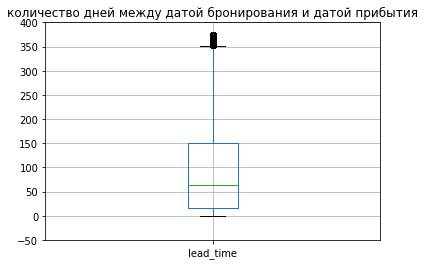

In [20]:
plt.ylim(-50, 400)
df_1['lead_time'].plot(kind='box', grid=True, legend=True,
                       title='количество дней между датой бронирования и датой прибытия');

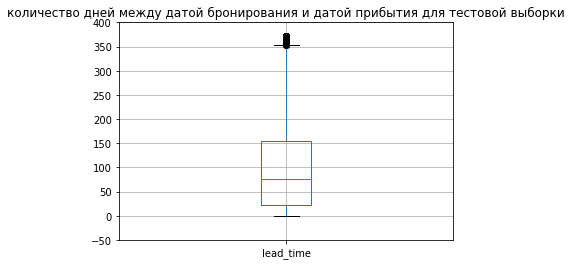

In [21]:
plt.ylim(-50, 400)
df_2['lead_time'].plot(kind='box', grid=True, legend=True,
                       title='количество дней между датой бронирования и датой прибытия для тестовой выборки');

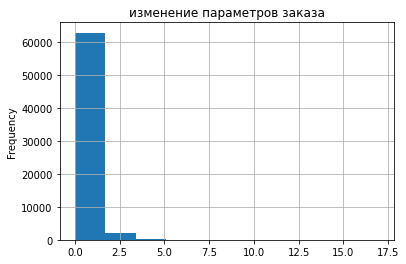

In [22]:
df_1['booking_changes'].plot(kind='hist', grid=True, title='изменение параметров заказа')
plt.show()

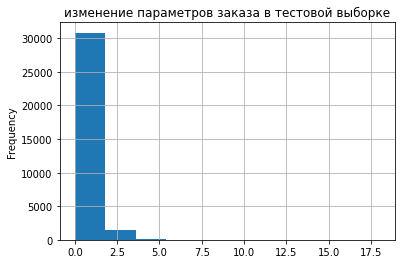

In [23]:
df_2['booking_changes'].plot(kind='hist', grid=True, title='изменение параметров заказа в тестовой выборке')
plt.show()

Исходя из графиков, можно понять что выбросы в колонке " количество дней между датой бронирования и датой прибытия" могут быть совсем не вбросами, а действительно сущетсвующими данными, так же и с количеством изменений, больше "5" их незначительное количество по сравнению и 1-3 изменениями, поэтому они сильно не повлияют на исследование

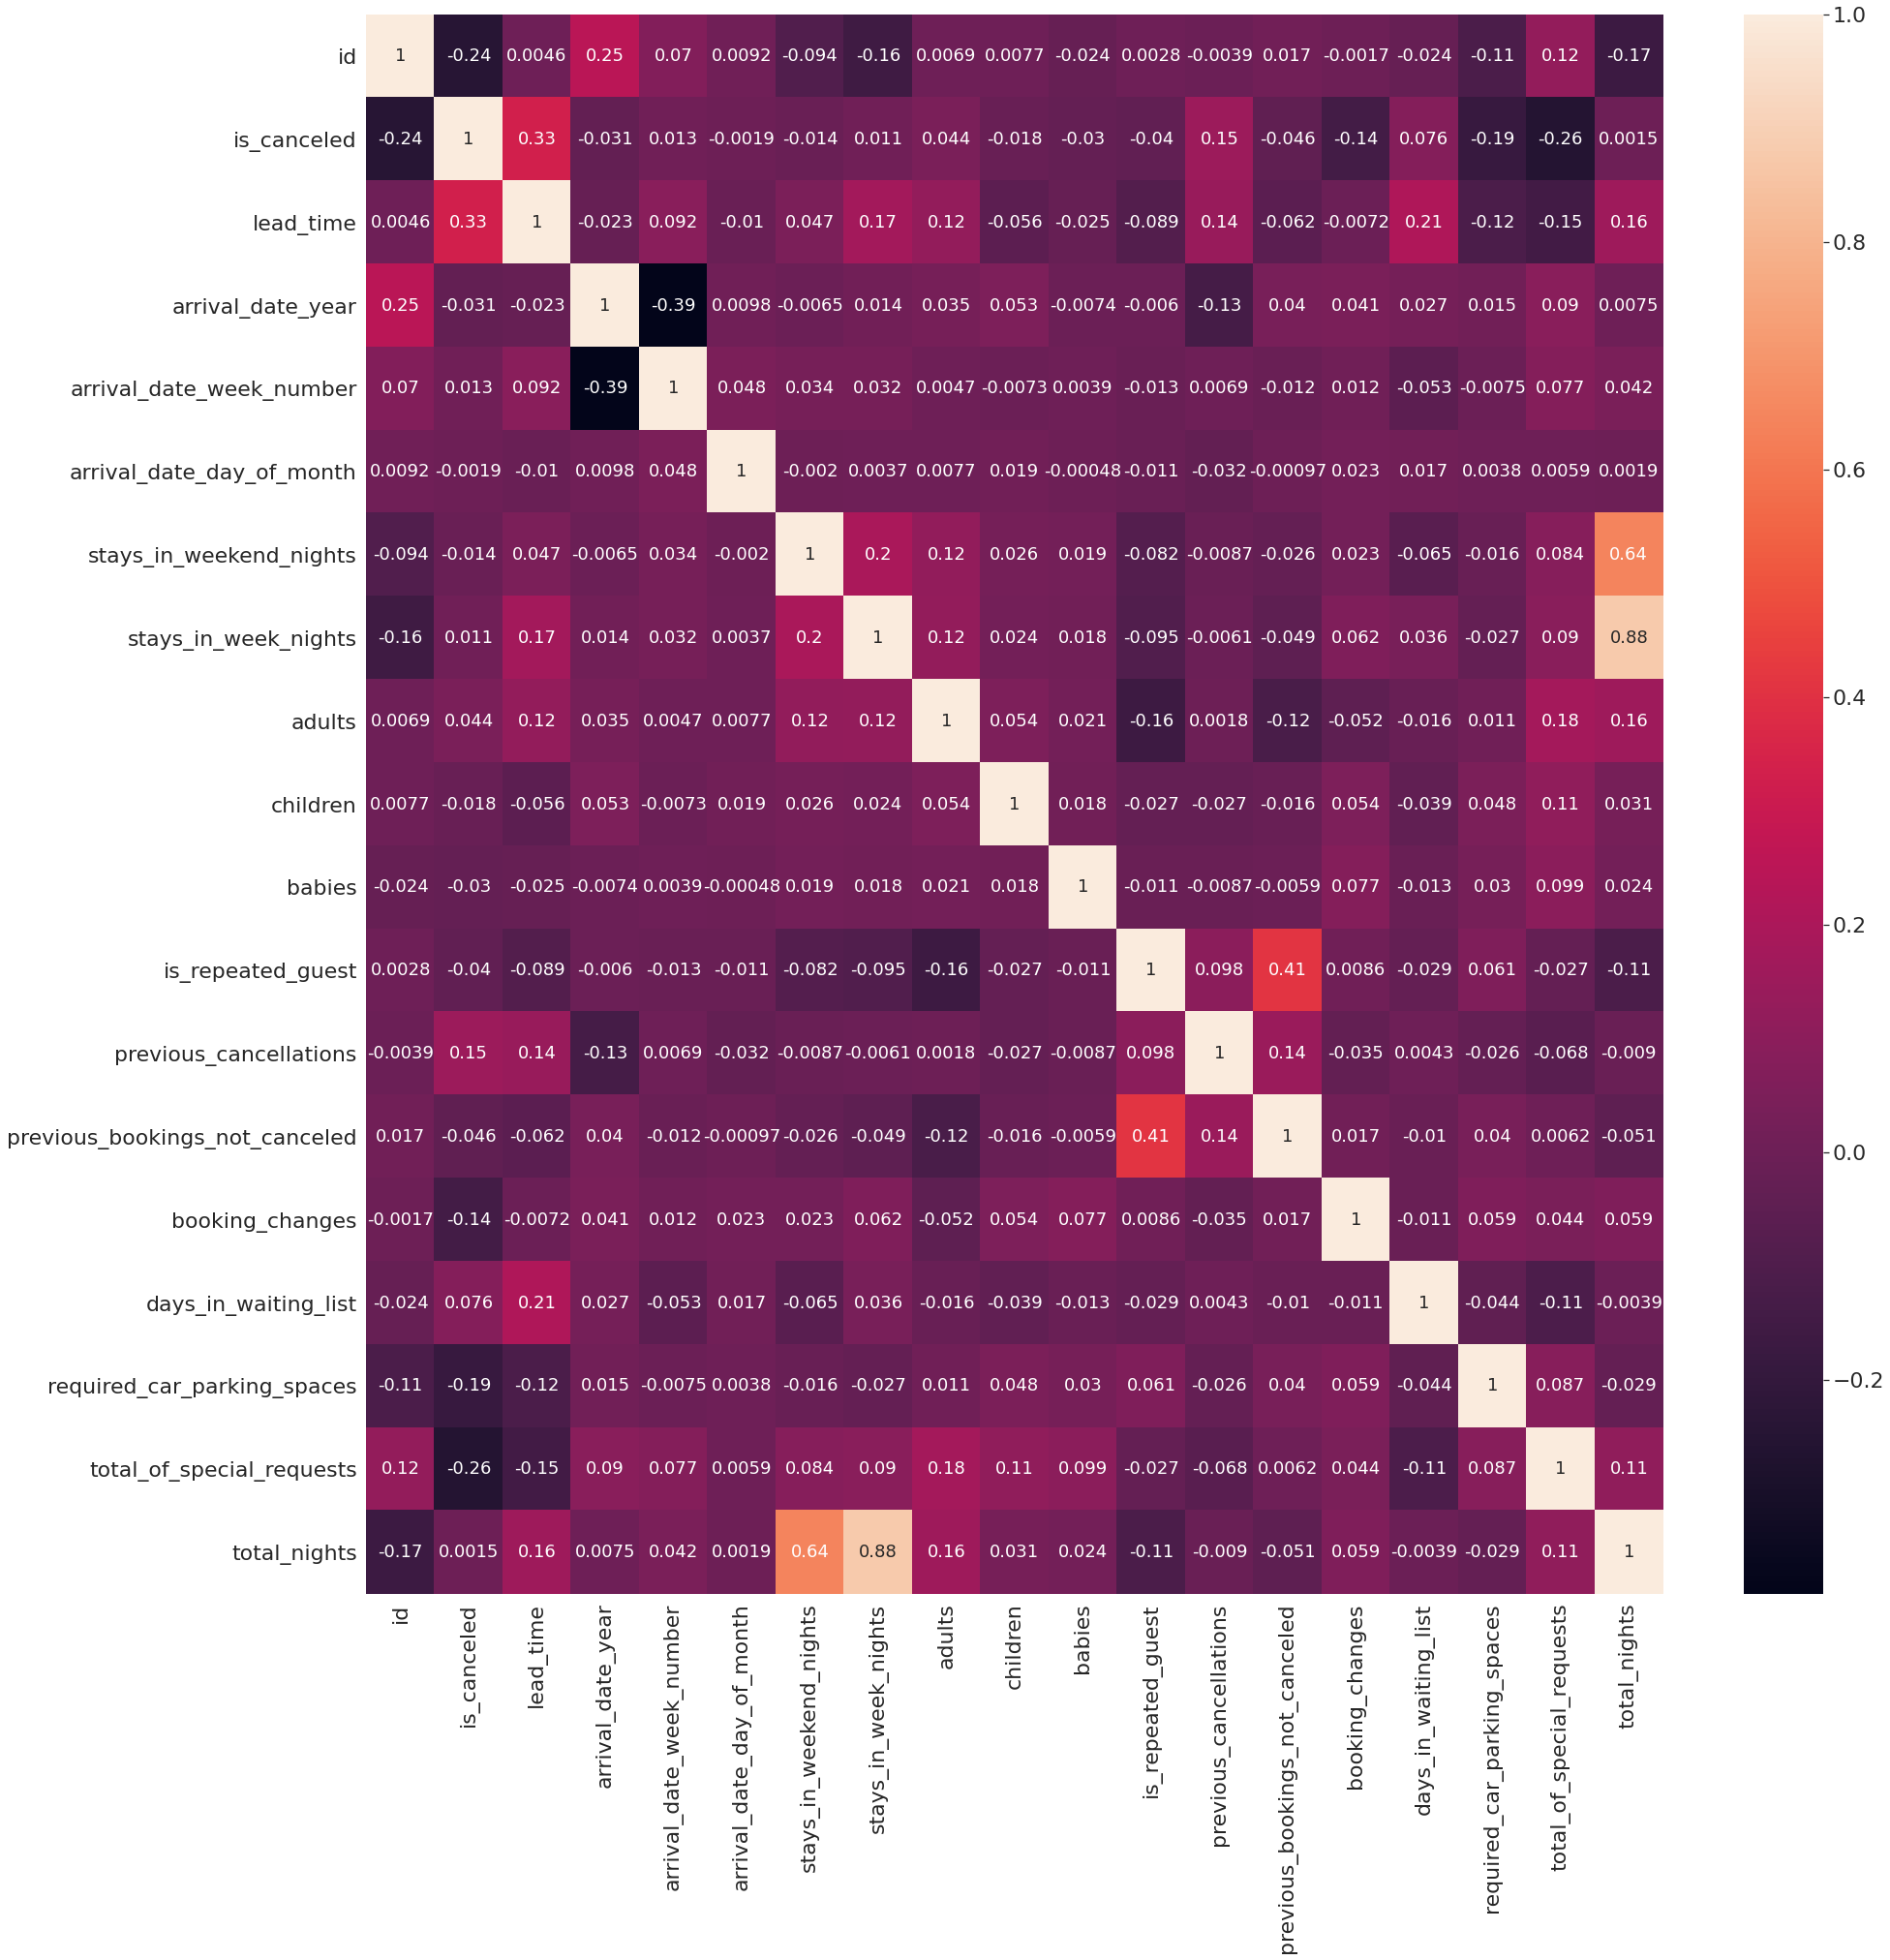

In [24]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)

sns.heatmap(df_1.corr(), annot = True, annot_kws={"fontsize":18});

(как мы видим из матрицы корреляции самая высокая зависимомть от `id` k `id`)

наибольшая зависимость отмены брони проявляется во времени до заезда(`lead_time`), и от того, отменял ли раньше клиент брони


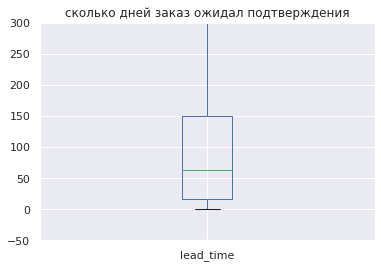

In [25]:
sns.set(font_scale=1)
plt.ylim(-50, 300)
df_1['lead_time'].plot(kind='box', grid=True, legend=True,
                       title='сколько дней заказ ожидал подтверждения');

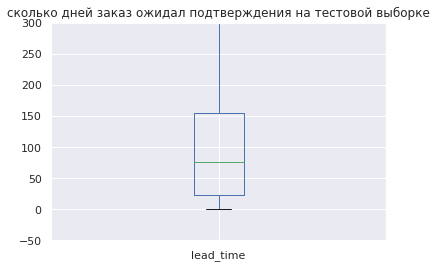

In [26]:
plt.ylim(-50, 300)
df_2['lead_time'].plot(kind='box', grid=True, legend=True,
                       title='сколько дней заказ ожидал подтверждения на тестовой выборке');

здесь так же нельзя сказать что это выбросы посколько в году 365 дней, за редким исключением, и данное количество дней заказ мог ожидать  подтвержения, чуть ниже я проверил, что подтверждение не длилось дольше (аааааааааааааааааааааааааааааааааа, как правильно это написать, если у меня 5 утра и мозг вышел из чата) дней в листе ожидания 

In [27]:
qwer = df_1['lead_time'] < df_1['days_in_waiting_list']
qwer.sum()


0

Оказалось, что таких строк нет=)

Посмотрим сколько было отмененных заказов

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

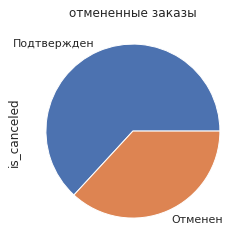

In [28]:
s = df_1['is_canceled'].value_counts(normalize=True)
s.plot(kind='pie', labels = ['Подтвержден', 'Отменен'], title='отмененные заказы')
s

0    0.611533
1    0.388467
Name: is_canceled, dtype: float64

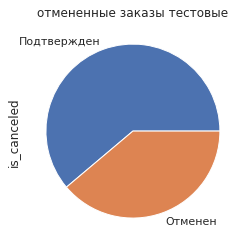

In [29]:
d = df_2['is_canceled'].value_counts(normalize=True)
d.plot(kind='pie', labels = ['Подтвержден', 'Отменен'], title='отмененные заказы тестовые')
d

Сильного дисбаланса нет, данные примерно равны

Посмотрим зависит ли отмена заказа от гражданства постояльца

In [30]:
# df_1.groupby('is_canceled')['country'].hist(bins=5, alpha=0.5, label='отмены от гражданства')
# plt.xlabel('strany')
# plt.ylabel('otmeny')
# plt.legend(['otm', 'ne otm'])
# plt.show()

Подправили данные в столбцах, избавились от выбросов данных, посмотрели на процент отменненных бронирований. 

Теперь данные готовы к работе и обучению

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Соберем в таблицы: стоимость проживания в раных номерах и коэффициента стоимости в зависимости от времени года

In [31]:
data = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                    'cost_night': [1000, 800, 600, 550, 500, 450, 350],
                    'one_time_service': [400, 350, 350, 150, 150, 150, 150]})
data

,reserved_room_type,cost_night,one_time_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [32]:
data_coef = pd.DataFrame({'arrival_date_month': ['January', 'February',
                                                 'March', 'April', 'May',
                                                 'June', 'July', 'August',
                                                 'September','October', 'November',
                                                 'December'], 
                         'coef': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0], 
                         'month_nomber': [1,2,3,4,5,6,7,8,9,10,11,12]})
data_coef

,arrival_date_month,coef,month_nomber
0,January,1.0,1
1,February,1.0,2
2,March,1.2,3
3,April,1.2,4
4,May,1.2,5
5,June,1.4,6
6,July,1.4,7
7,August,1.4,8
8,September,1.2,9
9,October,1.2,10


Присоеденим все к основным данным

In [33]:
df_1 = df_1.merge(data, on = 'reserved_room_type')
df_1 = df_1.merge(data_coef, on = 'arrival_date_month')
df_1.sample()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cost_night,one_time_service,coef,month_nomber
40695,44556,1,119.0,2016,December,52,24,1,1,2,...,0,0,Transient,0,0,2,550,150,1.0,12


In [34]:
df_2 = df_2.merge(data, on = 'reserved_room_type')
df_2 = df_2.merge(data_coef, on = 'arrival_date_month')
df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 0 to 32411
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  int64  
 10  children                        32412 non-null  int64  
 11  babies                          32412 non-null  int64  
 12  meal                            

Напишем функцию расчета выручки без внедрения допозитов

In [35]:
def without_deposit(x):
    if x['is_canceled'] == 0:
        profit = x['cost_night'] * x['total_nights'] * x['coef']
        expenses = x['one_time_service'] * (math.floor(x['total_nights']-1) / 2) + x['one_time_service']
    else:
        profit = 0
        expenses = x['one_time_service'] + x['cost_night']* x['coef']
    income = profit - expenses
    return income


In [36]:
profit_without_dep = df_1.apply(without_deposit, axis=1).sum()
print('Выручка отеля без внедрения депозитов: ', profit_without_dep)

Выручка отеля без внедрения депозитов:  69089270.0


### Шаг 4. Разработка модели ML

Выделим целевой признак и "фичи"

In [37]:
df_1.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cost_night,one_time_service,coef,month_nomber
0,0,0,7.0,2015,July,27,1,0,1,1,...,0,0,Transient,0,0,1,1000,400,1.4,7
1,1,0,14.0,2015,July,27,1,0,2,2,...,0,0,Transient,0,1,2,1000,400,1.4,7
2,4,1,85.0,2015,July,27,1,0,3,2,...,0,0,Transient,0,1,3,1000,400,1.4,7
3,10,0,0.0,2015,July,27,1,0,1,2,...,0,0,Transient,0,0,1,1000,400,1.4,7
4,12,0,72.0,2015,July,27,1,2,4,2,...,1,0,Transient,0,1,6,1000,400,1.4,7


сгруппируем странны, оставим 5 самых популярных гражданств, остальные переделаем в `other`

In [38]:
df_1['country'] = df_1['country'].astype('category')
others = df_1['country'].value_counts().index[5:]
label = 'Other'

df_1['country'] = df_1['country'].cat.add_categories([label])
df_1['country'] = df_1['country'].replace(others, label)

In [39]:
df_2['country'] = df_2['country'].astype('category')
others_test = df_2['country'].value_counts().index[5:]
label = 'Other'

df_2['country'] = df_2['country'].cat.add_categories([label])
df_2['country'] = df_2['country'].replace(others_test, label)

закодируем данные

In [40]:
df_train = pd.get_dummies(df_1, prefix=['arrival_date_month', 'meal', 'country',
                                        'distribution_channel', 'reserved_room_type', 'customer_type'],
                          columns=['arrival_date_month', 'meal', 'country', 'distribution_channel',
                                   'reserved_room_type', 'customer_type'], drop_first= True)

In [41]:
df_test = pd.get_dummies(df_2, prefix=['arrival_date_month', 'meal', 'country',
                                        'distribution_channel', 'reserved_room_type', 'customer_type'],
                          columns=['arrival_date_month', 'meal', 'country', 'distribution_channel',
                                   'reserved_room_type', 'customer_type'], drop_first= True)

In [42]:
target_train = df_train['is_canceled']
target_test = df_test['is_canceled']

features_train = df_train.drop(['is_canceled', 'id'], axis=1)
features_test = df_test.drop(['is_canceled', 'id'], axis=1)

features_train.sample()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
36289,68.0,2015,50,6,2,1,2,0,0,0,...,1,0,0,0,0,0,0,0,1,0


Обучим модель на тренировочных данных, используя модели случайного леса и дерева решений

Для оценки можелей будем использовать метрику `roc_auc`, выбираем мы ее потому что по ней, посмотрев на график можно легко определить качество нашей модели визуально

c помощью него выясним какая модель имеет лучшее качество

In [46]:
tree_param = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': range(5,55,10), 
    'min_samples_leaf': [2, 3, 5, 10],
    'class_weight':['balanced']
}



model_tree = GridSearchCV(DecisionTreeClassifier(random_state=12345), tree_param, cv=5, scoring='roc_auc')
model_tree.fit(features_train, target_train)
probabilities_tree = model_tree.predict_proba(features_train)
probabilities_one_tree = probabilities_tree[:, 1]
model_tree_auc_roc = roc_auc_score(target_train, probabilities_one_tree)


print(model_tree_auc_roc)
print('Лучшие параметры : ',model_tree.best_params_)

0.9065016612839635
Лучшие параметры :  {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 25}


In [47]:
forest_param = {
    'criterion':['gini','entropy'],
    'n_estimators': [2, 5, 10, 30, 50],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2, 3, 5, 10],
    'class_weight':['balanced']
}



model_forest = GridSearchCV(RandomForestClassifier(random_state=12345), forest_param, cv=5, scoring='roc_auc')
model_forest.fit(features_train, target_train)
probabilities_forest = model_forest.predict_proba(features_train)
probabilities_one_forest = probabilities_forest[:, 1]
model_forest_auc_roc = roc_auc_score(target_train, probabilities_one_forest)

print(model_forest_auc_roc)
print('Оптимальные параметры: ',model_forest.best_params_)

0.9489919208859271
Оптимальные параметры:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 10, 'n_estimators': 30}


Лушчший результат, с небольшим отрываом, показал метод случайного леса, его и будем использовать для обучения тестовой модели

In [64]:
model =  RandomForestClassifier(random_state=12345, max_depth=16, criterion='entropy',
                                n_estimators=30, min_samples_leaf=10,  class_weight='balanced')
model.fit(features_test, target_test)


predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)


In [65]:
print('Значение на тестовой выборке f1 меры: ', test_f1_score)
print('Значение на тестовой выборке auc_roc: ', auc_roc)

Значение на тестовой выборке f1 меры:  0.7746424129353234
Значение на тестовой выборке auc_roc:  0.9105213686158821


визуализируем результат auc_roc

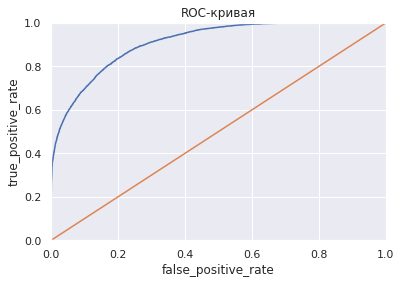

In [66]:
sns.set(font_scale=1)
v, b, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(v, b)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.title('ROC-кривая')
plt.show()

Посмотрим доход отеля с внедрением депозитов

In [67]:
df_2['predict'] = predicted_test

In [68]:
def with_deposit(x, y):
    if x['is_canceled'] == 0:
        profit = x['cost_night'] * x['total_nights'] * x['coef']
        expenses = x['one_time_service'] * (math.floor(x['total_nights']-1) / 2) + x['one_time_service']
    elif (x[y] == 0) and (x['is_canceled'] == 1):
        profit = 0
        expenses = x['one_time_service']
    elif (x[y] == 1) and (x['is_canceled'] == 1):
        profit= x['cost_night'] * 0.8
        expenses = x['one_time_service']+ x['cost_night']* x['coef']
    profit_row = profit - expenses
    return profit_row

In [69]:
df_2['profit_predict'] = df_2.apply(with_deposit, y='predict' , axis=1)

In [70]:
profit_with_dep = df_2['profit_predict'].sum()
print('Выручка отеля после внедрения депозитов:' , profit_with_dep)

Выручка отеля после внедрения депозитов: 43815105.0


в тестовой выборке у нас данные только за 8 месяцев, представим, сколько бы заработал отель за год и сранвним это число с обучающеней выборкой


In [71]:
profit_with_dep_year = profit_with_dep/8*12
profit_without_dep_year = profit_without_dep/2

Возьмем и там и там данные за год, так будет честнее

In [72]:
xy = pd.DataFrame({'Выручка отеля без внедрения депозитов' : [profit_without_dep_year], 
                  'Выручка отеля после внедрения депозитов' : [profit_with_dep_year]})


xy

,Выручка отеля без внедрения депозитов,Выручка отеля после внедрения депозитов
0,34544635.0,65722657.5


Кажется внедрение депозитов принесло должный результат

In [73]:
BUDGET = 400000
income = profit_with_dep_year - profit_without_dep_year - BUDGET
income

30778022.5

После внедрения системы депозитов компания увеличит свой доход в год 31млн, идея себя окупает

### Шаг 5. Опишите портрет «ненадёжного» клиента

Вызовем дискрайб и отсечем значения, где бронь отменена не была, и посмотрим портрет клиента, который обычно отменяет бронь

In [74]:
df_2.query('is_canceled==1 and predict==True').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,cost_night,one_time_service,coef,month_nomber,predict,profit_predict
count,9965.000000,9965.0,9965.000000,9965.0,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,...,9965.000000,9965.0,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.0,9965.000000
mean,43199.859207,1.0,134.990968,2017.0,18.311390,15.622980,0.847366,2.433417,1.914601,0.093427,...,0.469142,0.0,0.281184,3.280783,892.980432,345.258404,1.237792,4.647466,1.0,-734.771701
std,15953.282492,0.0,87.042387,0.0,8.571603,8.730674,0.861718,1.297601,0.443555,0.375646,...,5.840598,0.0,0.590481,1.601208,197.944952,102.661032,0.139408,1.970440,0.0,223.808636
min,6086.000000,1.0,1.000000,2017.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,1.000000,350.000000,150.000000,1.000000,1.000000,1.0,-1000.000000
25%,45955.000000,1.0,61.000000,2017.0,12.000000,8.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,0.0,0.000000,2.000000,1000.000000,400.000000,1.200000,3.000000,1.0,-1000.000000
50%,49148.000000,1.0,127.000000,2017.0,19.000000,15.000000,1.000000,2.000000,2.000000,0.000000,...,0.000000,0.0,0.000000,3.000000,1000.000000,400.000000,1.200000,5.000000,1.0,-800.000000
75%,52090.000000,1.0,186.000000,2017.0,25.000000,23.000000,2.000000,3.000000,2.000000,0.000000,...,0.000000,0.0,0.000000,4.000000,1000.000000,400.000000,1.400000,6.000000,1.0,-600.000000
max,55280.000000,1.0,373.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,...,183.000000,0.0,4.000000,10.000000,1000.000000,400.000000,1.400000,8.000000,1.0,-220.000000


И сразу посмотрим какой тип номеров предпочитают "отменяльщики"

In [75]:
df_2.query('is_canceled==1 and predict==True')['reserved_room_type'].value_counts(normalize=True) *100

A    76.899147
D    15.413949
E     3.883593
F     1.294531
G     1.003512
C     0.792775
B     0.712494
Name: reserved_room_type, dtype: float64

In [76]:
df_2.query('is_canceled==1 and predict==True')['arrival_date_month'].value_counts(normalize=True) *100

May         19.036628
April       18.253889
June        17.039639
March       10.556949
July        10.195685
February     8.329152
January      8.299047
August       8.289012
Name: arrival_date_month, dtype: float64

In [77]:
df_2.query('is_canceled==1 and predict==True')['meal'].value_counts(normalize=True) *100

BB    78.283994
SC    15.223281
HB     6.352233
FB     0.140492
Name: meal, dtype: float64

In [78]:
df_2.query('is_canceled==1 and predict==True')['distribution_channel'].value_counts(normalize=True) *100

TA/TO        94.560963
Corporate     3.120923
Direct        2.308078
GDS           0.010035
Name: distribution_channel, dtype: float64

http://joxi.ru/Vm6Ea10tKQQbYr я надеюсь это окончания на чешском языке

In [79]:
df_2.query('is_canceled==1 and predict==True')['is_repeated_guest'].value_counts(normalize=True) *100

0    100.0
Name: is_repeated_guest, dtype: float64

### Итак, обычно ненадежный клиент тот, кто:

    бронирует номер заранее ~124 дня
    приезжает на 3 дня
    обычно это 2 человека без детей
    номера класса А примерно 77%
    обычно приезжают в конце весны, начале лета 56%
    из опций еды выбирают только завтрак 79%
    выбирают в 95% случаев канал дистрибьюции ta/to(учат окончания на чешком языке)


    и 99.9% бронируют номер впервые
    
    
    

Так же можно сделать вывод, что это молодые пары, поскольку: без детей, обычно приезжают на выходные и куча планов за ранее, которые 100 раз поменяются, до отпуска

### Для бизнеса я бы реккомендовал ввести систему депозитов для постояльцев приезжающих в первый раз, использующих канал дистрибьюции ta/to, выбирающих номера класса "А"



### Шаг 6. Напишите общий вывод

Итак, по итогу проведенной работы можно сказать, что без депозитов выручка больше, почти в 2 раза(100 млн против 52), так же почти 38% бронирований отменяются, наилучший результат на обучении модели показал метод решающего дерева с глубиной 13.



Наилучший результат показала модель рандомного леса с гиперпараметрами :
max_depth=16, criterion='entropy',n_estimators=30, min_samples_leaf=10,  class_weight='balanced'

после внедрения системы депозитов, выручка значительно увеличится, примерно на 31млн в год, реккомендую пользоваться данной моделью и вводить систему депозитов